In [1]:
import sys, os, argparse, io
import numpy as np
from numpy.random import default_rng
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.stats
import unyt as u
# import sklearn.linear_model

In [2]:
T = 298.15 * u.K
beta = 1/(u.kb * T)
mu_ig_100angstroms = -48.860310174012 * u.Unit('kJ/mol')
w_ig_100angstroms = 0.3630331955330950617790E+09
V_empty = (100.0 * u.Angstrom) ** 3

In [3]:
kH_num = (w_ig_100angstroms * u.kb * T * 300 / V_empty).to_value("MPa")

In [4]:
def get_kH(w):
    return kH_num / w

In [5]:
# matplotlib.rc_file_defaults()
font = {
    "size": 12
}
legendfont = {}
plt.rc('axes.formatter', limits=[-3,4], use_mathtext=True)
plt.rc('ytick', right=True)
plt.rc('font', **font)
plt.rc("hist", bins=1000)
plt.rc("savefig", bbox="tight")
plt.rc("legend", fontsize=11)
# plt.rc("patch", linewidth=0)

In [6]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [7]:
def bootstrap(pilot_sample, statistic_function, ns=1000000, alpha=0.05, consolidator=lambda dummy: np.mean(dummy,axis=0)):
    # pilot_sample has one column per rv, one row per observation
    # alpha is the level of significance; 0.05 for 95% confidence interval
    pilot_sample = np.array(pilot_sample)
    n_obs = pilot_sample.shape[0]
    theta_shape = list(pilot_sample.shape)
    quantiles = np.array([alpha*0.5, 1.0-alpha*0.5])
    rng = default_rng()
    if consolidator is None:
        f1 = statistic_function
        f2 = None
        theta_orig = f1(pilot_sample)
        f1_shape = theta_orig.shape
    else:
        f1 = consolidator
        f2 = statistic_function
        consolidated_orig = f1(pilot_sample)
        f1_shape = consolidated_orig.shape
        theta_orig = f2(consolidated_orig)
#         print('theta_orig: ',theta_orig)
    
    theta_bs = np.zeros(tuple([ns]+list(f1_shape)))
#     print(theta_bs.shape)
#     print(pilot_sample[rng.integers(0,n_obs,n_obs)].shape)
#     print(f1(pilot_sample[rng.integers(0,n_obs,n_obs)]).shape)
    for ibs in range(ns):
        theta_bs[ibs,...] = f1(pilot_sample[rng.integers(0,n_obs,n_obs)])
#     print(theta_bs.shape)
    if f2 is not None:
        theta_bs = f2(theta_bs)
#     print(theta_bs.shape)
    # percentile CI
    CI_percentile = np.quantile(theta_bs, quantiles, 0)
    # jackknife
    theta_jk = np.zeros(tuple([n_obs]+list(f1_shape)))
    i_range = np.arange(n_obs)
    for i in i_range:
        theta_jk[i,...] = f1(pilot_sample[i_range != i,...])
    theta_jk = f2(theta_jk)
    theta_jk_mean = theta_jk.mean(0)
    theta_jk_diff = theta_jk_mean - theta_jk
    a = np.sum(theta_jk_diff**3,0) / (6*np.sum(theta_jk_diff**2,0)**1.5) # same shape as theta_orig
    z = scipy.stats.norm.ppf(quantiles).reshape(tuple([2]+[1]*theta_orig.ndim))
    # BCa CI
    z0 = scipy.stats.norm.ppf(np.sum(theta_bs < theta_orig,0)/ns) # bias-correction factor
    BCa_quantiles = scipy.stats.norm.cdf(z0+(z0+z)/(1-a*(z0+z)))
    CI_BCa = np.zeros(BCa_quantiles.shape)
    for index in np.ndindex(theta_orig.shape):
        ex_ind = (Ellipsis,)+index
        CI_BCa[ex_ind] = np.quantile(theta_bs[ex_ind],BCa_quantiles[ex_ind],0)
    return theta_orig, theta_bs, CI_percentile, CI_BCa
    

In [8]:
def block_avg(ary, nblocks, axis=0):
    return np.concatenate([np.mean(a,axis,keepdims=True) for a in np.split(ary,nblocks,axis=axis)],axis=axis)

In [9]:
n_ins = 50000000000
w_array = np.loadtxt("scheme1/n0/wprp.txt")
w_10_splits = w_array.mean(0)
sigma_wtest_1 = np.std(w_10_splits)*(n_ins/10)**0.5
sigma_wtest_2 = np.std(w_array)*100000**0.5
wtest = w_array.sum() * 100000

In [10]:
sigma_wtest_1

8190288845658.457

In [11]:
sigma_wtest_2

5580273983101.63

In [12]:
sigma_beta_mu_1 = sigma_wtest_1/wtest

In [13]:
sigma_beta_mu_1

3.5168112086996824e-07

In [14]:
sigma_mu_1 = (u.kb * (298.15 * u.K) * sigma_beta_mu_1).to('kJ/mol')

In [15]:
sigma_mu_1

unyt_quantity(8.71802337e-07, 'kJ/mol')

In [16]:
sem_w_1 = np.std(w_10_splits)/10.0**0.5
sem_w_1

36628085.22850118

In [17]:
prop_sigma_mu_1 = (sem_w_1 / w_array.mean() * u.kb * (298.15 * u.K)).to('kJ/mol')
prop_sigma_mu_1

unyt_quantity(0.19494093, 'kJ/mol')

In [18]:
sem_w_2 = np.std(w_array)/500000**0.5 
sem_w_2

24955743.91857751

In [19]:
w_array_s2 = np.loadtxt("scheme2/n0/wprp.txt")

In [20]:
prop_sigma_mu_1_s2 = (np.std(w_array_s2.mean(0)) / 10.0**0.5 / w_array_s2.mean() * u.kb * (298.15 * u.K)).to('kJ/mol')
prop_sigma_mu_1_s2

unyt_quantity(0.05599544, 'kJ/mol')

In [21]:
prop_sigma_mu_1_s2 * 1.96

unyt_quantity(0.10975106, 'kJ/mol')

In [22]:
prop_sigma_mu_2_s2 = (np.std(w_array_s2) / 500000**0.5 / w_array_s2.mean() * u.kb * (298.15 * u.K)).to('kJ/mol')
prop_sigma_mu_2_s2

unyt_quantity(0.06132983, 'kJ/mol')

In [23]:
prop_sigma_mu_2_s2 * 1.96

unyt_quantity(0.12020647, 'kJ/mol')

In [24]:
prop_sigma_mu_3_s2 = (np.std(w_array_s2.mean(1)) / 50000**0.5 / w_array_s2.mean() * u.kb * (298.15 * u.K)).to('kJ/mol')
prop_sigma_mu_3_s2

unyt_quantity(0.07978825, 'kJ/mol')

In [25]:
prop_sigma_mu_3_s2 * 1.96

unyt_quantity(0.15638497, 'kJ/mol')

In [26]:
T = 298.15 * u.K

In [27]:
mu_10_splits = (-u.kb * T * np.log(w_10_splits)).to('kJ/mol')
mu_10_splits

unyt_array([-48.95778413, -49.60007909, -49.54725383, -48.86283467,
            -48.64891358, -49.93249086, -50.24021481, -48.80172502,
            -49.06301172, -50.39296197], 'kJ/mol')

In [28]:
np.std(mu_10_splits).to('kJ/mol')

unyt_quantity(0.59638068, 'kJ/mol')

In [29]:
mu_10_splits_s2 = (-u.kb * T * np.log(np.loadtxt("scheme2/n0/wprp.txt").mean(0))).to('kJ/mol')
mu_10_splits_s2

unyt_array([-49.62450236, -49.26076132, -49.450003  , -49.00035021,
            -49.62870952, -49.30139692, -49.38769894, -49.24649472,
            -49.27509931, -49.41867136], 'kJ/mol')

In [30]:
np.std(mu_10_splits_s2).to('kJ/mol')

unyt_quantity(0.17809958, 'kJ/mol')

In [31]:
np.std(mu_10_splits_s2).to('kJ/mol')*10**0.5

unyt_quantity(0.56320033, 'kJ/mol')

In [32]:
wtest

2.328896366514585e+19

In [33]:
a = np.random.randint(100, size=(3,3))
a

array([[35, 68, 36],
       [19, 97, 37],
       [79, 31, 39]])

In [34]:
a+np.arange(3)

array([[35, 69, 38],
       [19, 98, 39],
       [79, 32, 41]])

In [35]:
a+np.arange(3).reshape(1,-1)

array([[35, 69, 38],
       [19, 98, 39],
       [79, 32, 41]])

In [36]:
a+np.arange(3).reshape(-1,1)

array([[35, 68, 36],
       [20, 98, 38],
       [81, 33, 41]])

In [37]:
a.ndim

2

In [38]:
def cumavg(a, axis=0):
    rs = np.ones(a.ndim,dtype=int)
    rs[axis] = -1
    rs = tuple(rs)
    return np.cumsum(a,axis=axis)/(np.arange(a.shape[axis])+1).reshape(rs)

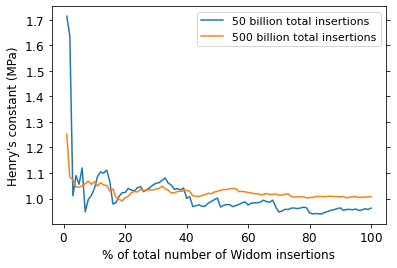

In [39]:
plt.figure()
plt.plot(np.arange(100)+1,np.loadtxt('scheme1/H_convergence.txt'),np.arange(100)+1,np.loadtxt('scheme2/H_convergence.txt'))
#plt.title("Convergence of Henry's constant of R-32 in BMIM-PF6")
plt.legend(['50 billion total insertions', '500 billion total insertions'])
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')
plt.show()
# plt.savefig("kH_vs_percent_insertions.eps")

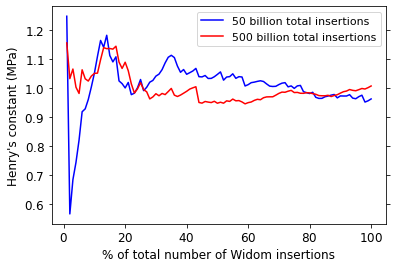

In [40]:
plt.plot(np.arange(100)+1, get_kH(cumavg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0].mean(axis=1),100))), 'b-',np.arange(100)+1,get_kH(cumavg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0].mean(axis=1),100))),'r-')
# plt.hlines(CI_BCa_s1[...,0,1], xmin=0.0, xmax=100.0, colors='b', linestyles='dashed')
# plt.hlines(CI_BCa[...,0,1], xmin=0.0, xmax=100.0, colors='r', linestyles='dashed')
#plt.title("Convergence of Henry's constant of R-32 in BMIM-PF6")
plt.legend(['50 billion total insertions', '500 billion total insertions'])
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')
plt.show()

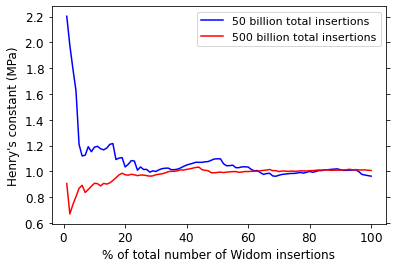

In [41]:
plt.plot(np.arange(100)+1, get_kH(cumavg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0].mean(axis=0),100))), 'b-',np.arange(100)+1,get_kH(cumavg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0].mean(axis=0),100))),'r-')
# plt.hlines(CI_BCa_s1[...,0,1], xmin=0.0, xmax=100.0, colors='b', linestyles='dashed')
# plt.hlines(CI_BCa[...,0,1], xmin=0.0, xmax=100.0, colors='r', linestyles='dashed')
#plt.title("Convergence of Henry's constant of R-32 in BMIM-PF6")
plt.legend(['50 billion total insertions', '500 billion total insertions'])
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')
plt.show()

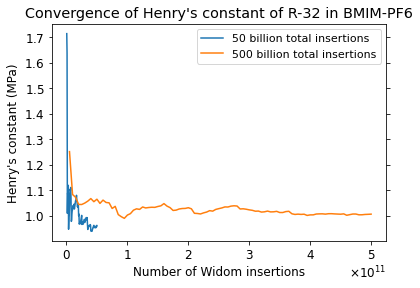

In [42]:
plt.plot((np.arange(100)+1)*5e8,np.loadtxt('scheme1/H_convergence.txt'),(np.arange(100)+1)*5e9,np.loadtxt('scheme2/H_convergence.txt'))
plt.title("Convergence of Henry's constant of R-32 in BMIM-PF6")
plt.legend(['50 billion total insertions', '500 billion total insertions'])
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('Number of Widom insertions')
plt.show()

In [43]:
np.loadtxt('scheme1/H_convergence.txt')[-1]

0.962533

In [44]:
np.loadtxt('scheme2/H_convergence.txt')[-1]

1.007145

Text(0.5, 0, '% of total number of Widom insertions')

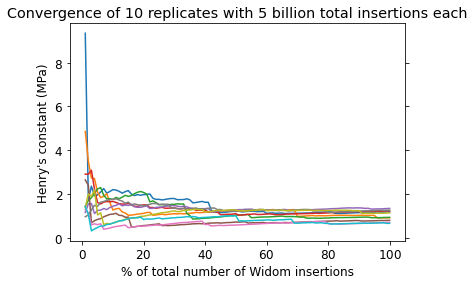

In [45]:
plt.figure()
plt.plot(np.arange(100)+1,np.loadtxt('scheme1/H_convergence_multirep.txt'))
plt.title("Convergence of 10 replicates with 5 billion total insertions each")
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')

Text(0.5, 0, '% of total number of Widom insertions')

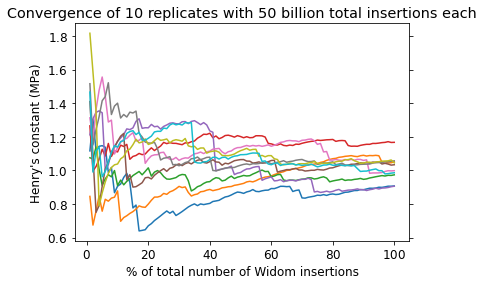

In [46]:
plt.figure()
plt.plot(np.arange(100)+1,np.loadtxt('scheme2/H_convergence_multirep.txt'))
plt.title("Convergence of 10 replicates with 50 billion total insertions each")
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')

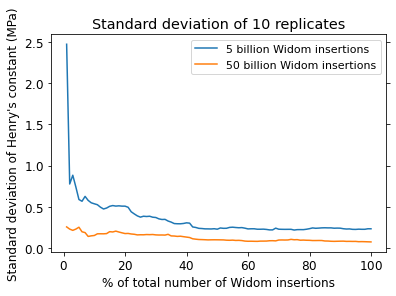

In [47]:
plt.figure()
plt.plot(np.arange(100)+1,np.loadtxt('scheme1/H_convergence_std.txt'),np.arange(100)+1,np.loadtxt('scheme2/H_convergence_std.txt'))
plt.title("Standard deviation of 10 replicates")
plt.ylabel("Standard deviation of Henry's constant (MPa)")
plt.xlabel("% of total number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])

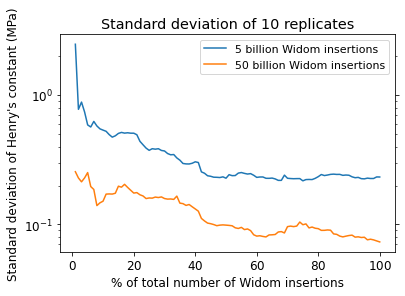

In [48]:
plt.figure()
plt.semilogy(np.arange(100)+1,np.loadtxt('scheme1/H_convergence_std.txt'),np.arange(100)+1,np.loadtxt('scheme2/H_convergence_std.txt'))
plt.title("Standard deviation of 10 replicates")
plt.ylabel("Standard deviation of Henry's constant (MPa)")
plt.xlabel("% of total number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])

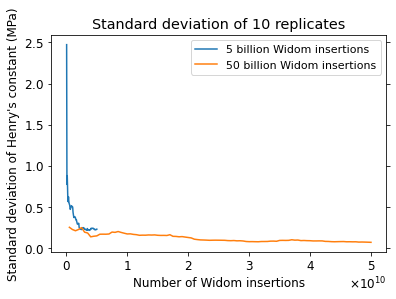

In [49]:
plt.figure()
plt.plot((np.arange(100)+1)*5e7,np.loadtxt('scheme1/H_convergence_std.txt'),(np.arange(100)+1)*5e8,np.loadtxt('scheme2/H_convergence_std.txt'))
plt.title("Standard deviation of 10 replicates")
plt.ylabel("Standard deviation of Henry's constant (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


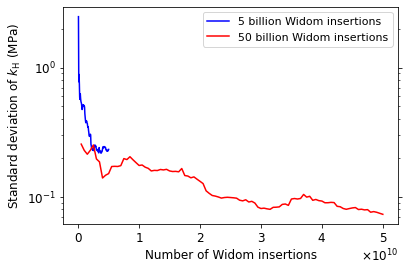

In [50]:
plt.figure()
plt.semilogy((np.arange(100)+1)*5e7,np.loadtxt('scheme1/H_convergence_std.txt'), 'b-',(np.arange(100)+1)*5e8,np.loadtxt('scheme2/H_convergence_std.txt'), 'r-')
#plt.title("Standard deviation of 10 replicates")
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
#plt.tick_params(labelright=True)
plt.savefig("kH_std_semilog.eps")
plt.savefig("kH_std_semilog.png")

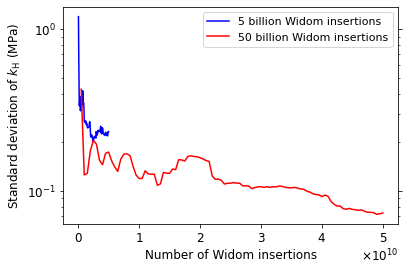

In [53]:
plt.semilogy((np.arange(100)+1)*5e7, np.std(get_kH(cumavg(block_avg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0],10,axis=1),100))),axis=1), 'b-',(np.arange(100)+1)*5e8,np.std(get_kH(cumavg(block_avg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0],10,axis=1),100))),axis=1),'r-')
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
plt.show()

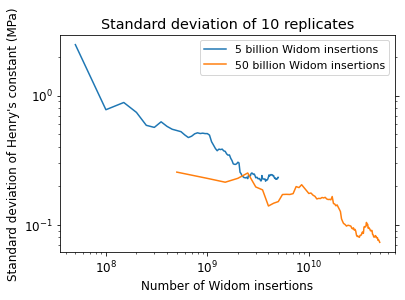

In [54]:
plt.figure()
plt.loglog((np.arange(100)+1)*5e7,np.loadtxt('scheme1/H_convergence_std.txt'),(np.arange(100)+1)*5e8,np.loadtxt('scheme2/H_convergence_std.txt'))
plt.title("Standard deviation of 10 replicates")
plt.ylabel("Standard deviation of Henry's constant (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])

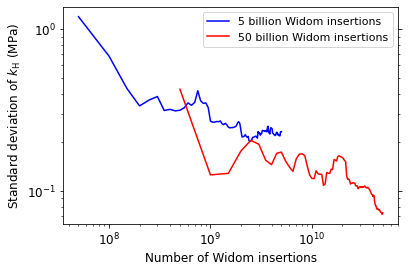

In [55]:
plt.loglog((np.arange(100)+1)*5e7, np.std(get_kH(cumavg(block_avg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0],10,axis=1),100))),axis=1), 'b-',(np.arange(100)+1)*5e8,np.std(get_kH(cumavg(block_avg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0],10,axis=1),100))),axis=1),'r-')
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
plt.show()

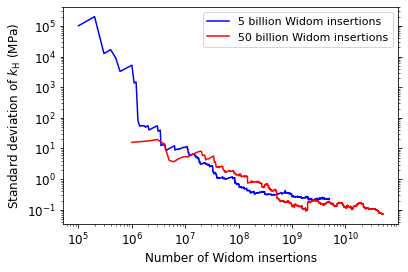

In [58]:
plt.loglog((np.arange(50000)+1)*1e5, np.std(get_kH(cumavg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0],10,axis=1))),axis=1), 'b-',(np.arange(50000)+1)*1e6,np.std(get_kH(cumavg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0],10,axis=1))),axis=1),'r-')
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
plt.show()

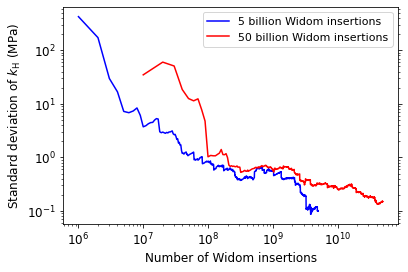

In [59]:
plt.loglog((np.arange(5000)+1)*1e6,
           np.std(get_kH(cumavg(np.stack(np.split(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0].mean(axis=1),10,axis=0),axis=-1))),axis=-1),
           'b-',
           (np.arange(5000)+1)*1e7,
           np.std(get_kH(cumavg(np.stack(np.split(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0].mean(axis=1),10,axis=0),axis=-1))),axis=-1),
           'r-')
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
plt.show()

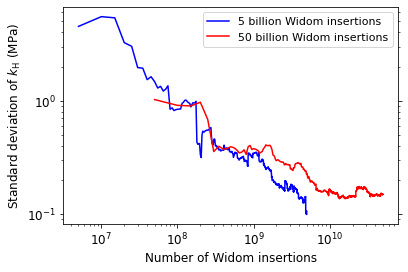

In [60]:
plt.loglog((np.arange(1000)+1)*5e6,
           np.std(get_kH(cumavg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0],10,axis=0),axis=1)),axis=0),
           'b-',
           (np.arange(1000)+1)*5e7,
           np.std(get_kH(cumavg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0],10,axis=0),axis=1)),axis=0),
           'r-')
plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
plt.xlabel("Number of Widom insertions")
plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
plt.tick_params(which='both', right=True)
plt.show()

In [ ]:
# plt.loglog((np.arange(50000)+1)*1e5, np.std(get_kH(cumavg(block_avg(np.load('scheme1/dstack_hcat_wprp2.npy')[...,0],10,axis=0))),axis=1), 'b-',(np.arange(50000)+1)*1e6,np.std(get_kH(cumavg(block_avg(np.load('scheme2/dstack_hcat_wprp2.npy')[...,0],10,axis=1))),axis=1),'r-')
# plt.ylabel(r"Standard deviation of $k_\mathrm{H}$ (MPa)")
# plt.xlabel("Number of Widom insertions")
# plt.legend(["5 billion Widom insertions","50 billion Widom insertions"])
# plt.tick_params(which='both', right=True)
# plt.show()

In [44]:
def read_prp(filename):
    with open(filename) as fprp:
        fprp.readline()
        colnames = fprp.readline()[1:].strip().split()
        colunits = fprp.readline()[1:].strip().split()
        df = pd.read_csv(fprp, delim_whitespace=True, index_col=False, names=colnames)
    return df

In [45]:
propdata = pd.read_csv('property_data.csv')
propdata.Pressure *= 0.1

Text(0.5, 0, "$\\mu'$")

<Figure size 432x288 with 0 Axes>

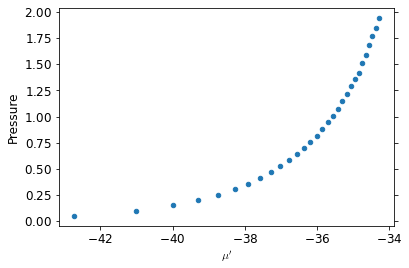

In [46]:
plt.figure()
propdata.plot.scatter(x='mu', y='Pressure')
plt.xlabel("$\mu'$", usetex=True)

In [47]:
P_f_mu_linear = interpolate.interp1d(propdata['mu'], propdata['Pressure'], bounds_error=False, fill_value=0.0)
P_f_mu_cubic = interpolate.interp1d(propdata['mu'], propdata['Pressure'], kind='cubic', bounds_error=False, fill_value=0.0)

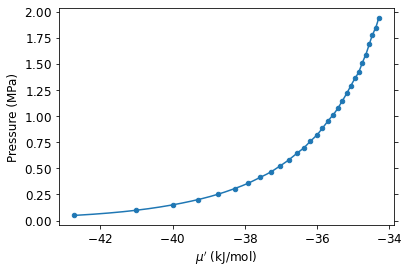

In [48]:
#font = {'size': 12}
propdata.plot.scatter(x='mu', y='Pressure')
plt.plot(np.arange(propdata.mu.iloc[0],propdata.mu.iloc[-1],0.01), P_f_mu_cubic(np.arange(propdata.mu.iloc[0],propdata.mu.iloc[-1],0.01)))
plt.ylabel("Pressure (MPa)")
plt.xlabel(r"$\mu'$ (kJ/mol)")
plt.savefig("P_vs_mu_r32.eps")
plt.show()

In [49]:
n_array = [0,60,260,500,800]
n_vec = np.array(n_array)
xvec = n_vec/(n_vec+300)
xvec_multirep = np.repeat(xvec,10)
xvec_multirep

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.46428571, 0.46428571, 0.46428571, 0.46428571, 0.46428571,
       0.46428571, 0.46428571, 0.46428571, 0.46428571, 0.46428571,
       0.625     , 0.625     , 0.625     , 0.625     , 0.625     ,
       0.625     , 0.625     , 0.625     , 0.625     , 0.625     ,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273])

In [50]:
mu_s2_multirep = np.concatenate([np.loadtxt('scheme2/n'+str(nsolute)+'/rmu_multirep.txt')[-1,:] for nsolute in n_array])
mu_s2 = np.array([np.loadtxt('scheme2/n'+str(nsolute)+'/rmu.txt')[-1] for nsolute in n_array])

In [51]:
mu_s2_multirep

array([-49.624502, -49.260761, -49.450003, -49.00035 , -49.62871 ,
       -49.301397, -49.387699, -49.246495, -49.275099, -49.418671,
       -39.278498, -39.346411, -39.387514, -39.301971, -39.294938,
       -39.674793, -39.285774, -39.092828, -39.193988, -39.266097,
       -36.601005, -36.695659, -36.47155 , -36.219314, -36.848281,
       -36.423666, -36.290227, -37.113195, -36.633035, -36.878268,
       -35.551384, -35.774168, -35.695721, -35.476598, -35.675199,
       -35.59368 , -35.524049, -35.526551, -35.65822 , -35.569653,
       -35.148124, -35.323426, -35.211843, -35.125808, -35.253256,
       -35.180769, -35.270264, -35.189644, -35.321794, -35.263879])

In [52]:
mu_s2

array([-49.365738, -39.31651 , -36.631609, -35.606104, -35.229736])

In [53]:
P_s2_multirep = P_f_mu_cubic(mu_s2_multirep)
P_s2_multirep

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2023134 , 0.1967819 , 0.19350239, 0.20038549, 0.20096134,
       0.17196346, 0.20171397, 0.21822231, 0.20940219, 0.20333889,
       0.63263499, 0.60535872, 0.666639  , 0.74695189, 0.56406281,
       0.67928701, 0.72162956, 0.50243785, 0.62352298, 0.55680425,
       1.01289615, 0.91972583, 0.9539804 , 1.04793302, 0.96238248,
       0.99504856, 1.02518154, 1.02403163, 0.96920649, 1.00502995,
       1.23625749, 1.13173978, 1.19683179, 1.25063824, 1.17239088,
       1.21572371, 1.16250228, 1.2102663 , 1.13268294, 1.16620816])

In [54]:
P_s2 = P_f_mu_cubic(mu_s2)
P_s2

array([0.        , 0.19919988, 0.62393301, 0.99000619, 1.18619047])

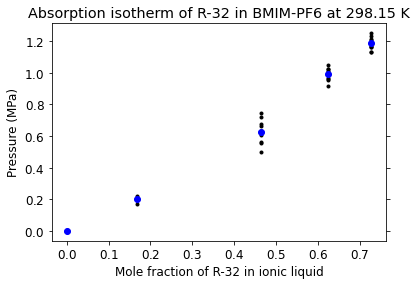

In [55]:
plt.plot(xvec_multirep,P_s2_multirep,'k.',
        xvec,P_s2,'bo')
plt.xlabel('Mole fraction of R-32 in ionic liquid')
plt.ylabel('Pressure (MPa)')
plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.show()

In [56]:
hrex_df = pd.read_csv('../../gcmc/results_final.txt', delim_whitespace=True)
hrex_df

,x_molfraction,P_MPa
0,0.000,0.005
1,0.032,0.039
2,0.118,0.134
3,0.167,0.202
4,0.211,0.246
5,0.318,0.409
6,0.464,0.671
7,0.625,0.973
8,0.727,1.186


In [57]:
pressure_df = pd.DataFrame(index=n_array, columns=['x_R32', 'Pressure', 'Pressure_SEM'])
for i, n in enumerate(n_array):
    prpdf = read_prp('../../gcmc/equilibrium_pressures/n'+str(n)+'_prod.out.prp')
    prp_mean = prpdf.mean(axis=0)
    prp_sem = prpdf.sem(axis=0)
    pressure_df['Pressure'][n] = prp_mean['Pressure']
    pressure_df['Pressure_SEM'][n] = prp_sem['Pressure']
    pressure_df['x_R32'][n] = n/(n+300)

In [58]:
P_exp = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
x_exp = np.array([3.9, 7.6, 14.6, 27.3, 38.4, 48.3, 57.4])*0.01

In [60]:
volume_array = np.load('scheme2/volume_array.npy') * u.nm ** 3
V_mean_array = volume_array.mean(0)
density = 300.0 / V_mean_array
beta = 1/(u.kb * T)

In [61]:
def mushift(w):
    T = 298.15 * u.K
    mu = - u.kb * T * np.log(w)
    return mu.to_value('kJ/mol')

In [62]:
mu_ig = (mu_ig_100angstroms + u.kb*T*np.log((n_vec+1)*V_empty/V_mean_array)).to_value('kJ/mol')

In [63]:
def statfunc(bs):
    nst = bs.shape[:-1]
    theta = np.zeros(nst+(5,2))
    theta[...,0] = mushift(bs)
    theta[...,0,1] = (u.kb * T * density[0] * np.exp((theta[...,0,0] - mu_ig[0])*beta.to_value('mol/kJ'))).to_value('MPa')
    theta[...,1:,1] = P_f_mu_cubic(theta[...,1:,0])
    return theta

In [5]:
dstack_hcat_wprp2 = np.load('scheme2/dstack_hcat_wprp2.npy')

In [6]:
dstack_hcat_wprp2.shape

(50000, 1000, 5)

In [8]:
sys.getsizeof(dstack_hcat_wprp2)

2000000136

In [64]:
if not all([os.path.exists(p+".npy") for p in ("theta_orig", "theta_bs", "CI_percentile", "CI_BCa")]):
    theta_orig, theta_bs, CI_percentile, CI_BCa = bootstrap(dstack_hcat_wprp2.mean(0),
                                                            statistic_function = statfunc)
    np.save("theta_orig.npy", theta_orig)
    np.save("theta_bs.npy", theta_bs)
    np.save("CI_percentile.npy", CI_percentile)
    np.save("CI_BCa.npy", CI_BCa)
else:
    theta_orig = np.load("theta_orig.npy")
    theta_bs = np.load("theta_bs.npy")
    CI_percentile = np.load("CI_percentile.npy")
    CI_BCa = np.load("CI_BCa.npy")

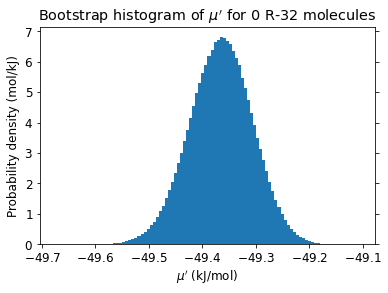

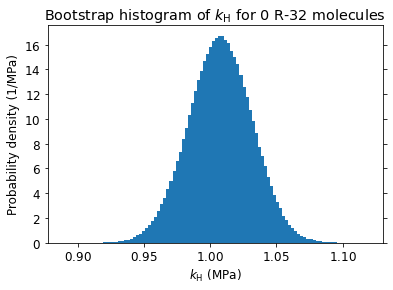

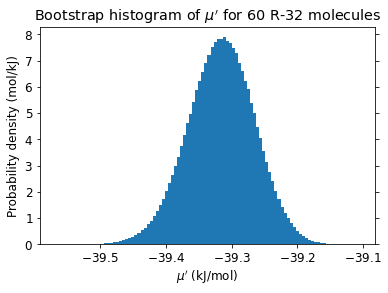

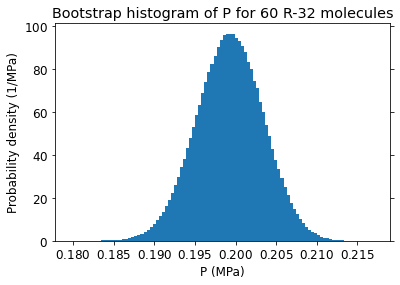

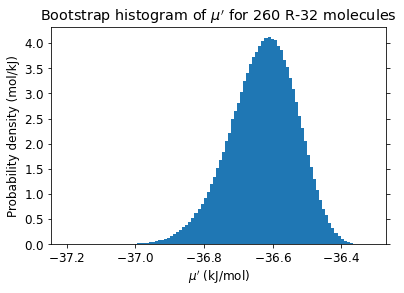

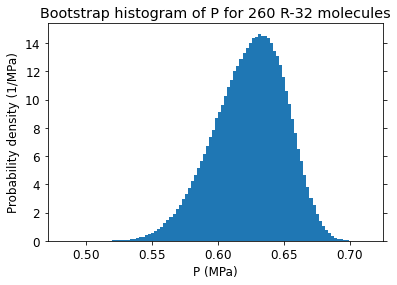

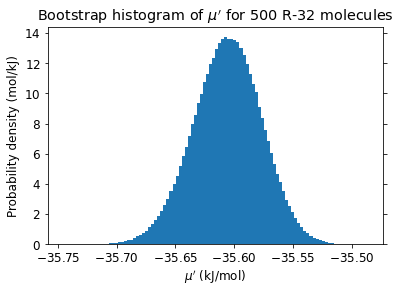

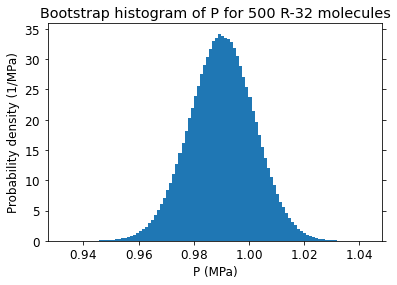

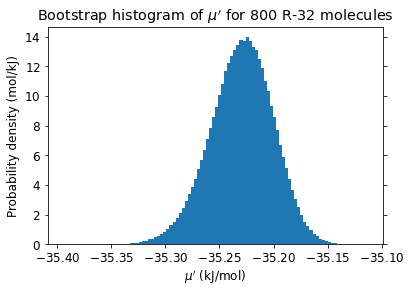

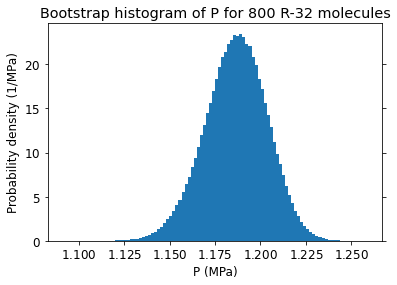

In [65]:
for i, n_solute in enumerate(n_array):
    plt.hist(theta_bs[:,i,0], bins=100, density=True)
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    plt.show()
    plt.hist(theta_bs[:,i,1], bins=100, density=True)
    if i:
        theta_variable = "P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.show()

In [66]:
CI_BCa

array([[[-49.49339714,   0.95658605],
        [-39.42850494,   0.19028082],
        [-36.90468355,   0.55080367],
        [-35.66879812,   0.96496097],
        [-35.29885341,   1.14593525]],

       [[-49.26070406,   1.05072934],
        [-39.22750211,   0.20656136],
        [-36.48785016,   0.66254282],
        [-35.55420441,   1.01166036],
        [-35.18193031,   1.21499657]]])

In [67]:
CI_BCa.shape

(2, 5, 2)

In [68]:
CI_BCa[...,1]

array([[0.95658605, 0.19028082, 0.55080367, 0.96496097, 1.14593525],
       [1.05072934, 0.20656136, 0.66254282, 1.01166036, 1.21499657]])

In [69]:
CI_percentile[...,1]

array([[0.96064896, 0.19109168, 0.56701278, 0.9668338 , 1.15135383],
       [1.05420512, 0.20723037, 0.67036571, 1.01324126, 1.21859515]])

In [70]:
CI_BCa[0,...]

array([[-49.49339714,   0.95658605],
       [-39.42850494,   0.19028082],
       [-36.90468355,   0.55080367],
       [-35.66879812,   0.96496097],
       [-35.29885341,   1.14593525]])

In [71]:
theta_orig

array([[-49.36573773,   1.00714548],
       [-39.31651021,   0.19919986],
       [-36.63160896,   0.62393302],
       [-35.6061043 ,   0.99000607],
       [-35.22973573,   1.18619063]])

In [72]:
(CI_BCa - theta_orig)[...,1]

array([[-0.05055943, -0.00891904, -0.07312935, -0.0250451 , -0.04025538],
       [ 0.04358387,  0.0073615 ,  0.0386098 ,  0.02165429,  0.02880595]])

In [73]:
yerr_BCa = np.abs(CI_BCa - theta_orig)
yerr_BCa_P = yerr_BCa[...,1:,1]
P_orig = theta_orig[...,1:,1]
mu_shift_orig = theta_orig[...,0]
yerr_BCa_mu = yerr_BCa[...,0]
yerr_BCa_kH = yerr_BCa[...,0,1]
kH_orig = theta_orig[...,0,1]
yerr_q = np.abs(CI_percentile - theta_orig)
yerr_q_P = yerr_q[...,1:,1]
yerr_q_mu = yerr_q[...,0]
yerr_q_kH = yerr_q[...,0,1]

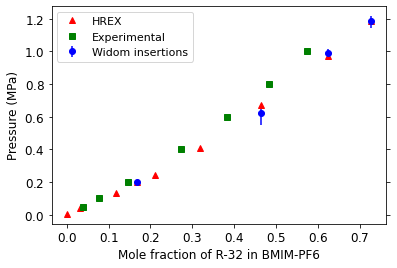

In [74]:
plt.plot(hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.errorbar(xvec[1:], P_orig, yerr=yerr_BCa_P, fmt='bo')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
#plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['HREX', 'Experimental', 'Widom insertions'])
plt.show()

In [75]:
yerr_BCa_mu

array([[0.12765942, 0.11199473, 0.27307459, 0.06269383, 0.06911768],
       [0.10503367, 0.0890081 , 0.1437588 , 0.05189989, 0.04780542]])

In [76]:
yerr_q_mu

array([[0.11717111, 0.10163197, 0.20475104, 0.05804272, 0.05978396],
       [0.11320645, 0.09693305, 0.17445774, 0.05550737, 0.05360062]])

In [77]:
if not all([os.path.exists(p+"_100sq.npy") for p in ("theta_orig", "theta_bs", "CI_percentile", "CI_BCa")]):
    theta_orig_100sq, theta_bs_100sq, CI_percentile_100sq, CI_BCa_100sq = bootstrap(np.reshape(block_avg(block_avg(dstack_hcat_wprp2, 100, 0), 100, 1), (10000,5)),
                                                            statistic_function = statfunc)
    np.save("theta_orig_100sq.npy", theta_orig_100sq)
    np.save("theta_bs_100sq.npy", theta_bs_100sq)
    np.save("CI_percentile_100sq.npy", CI_percentile_100sq)
    np.save("CI_BCa_100sq.npy", CI_BCa_100sq)
else:
    theta_orig_100sq = np.load("theta_orig_100sq.npy")
    theta_bs_100sq = np.load("theta_bs_100sq.npy")
    CI_percentile_100sq = np.load("CI_percentile_100sq.npy")
    CI_BCa_100sq = np.load("CI_BCa_100sq.npy")

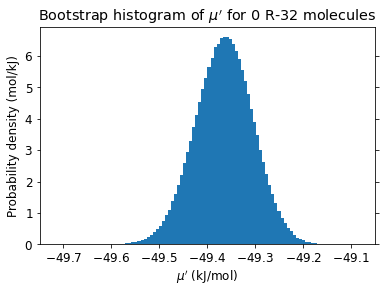

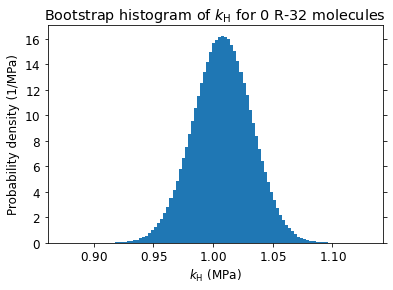

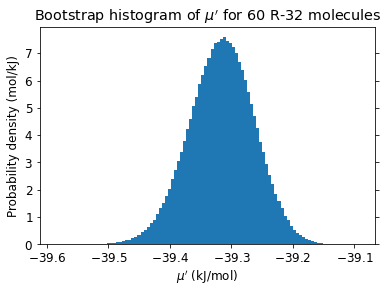

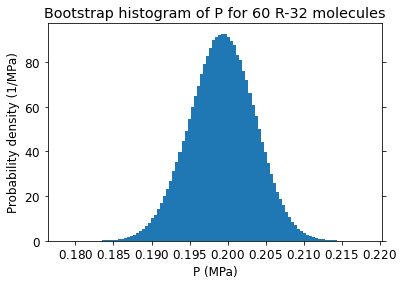

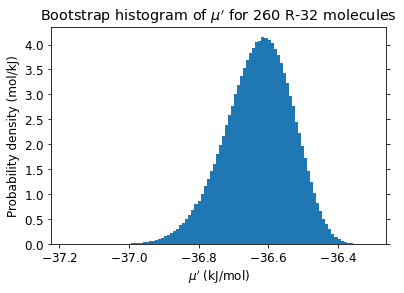

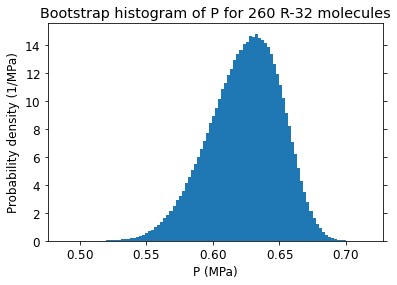

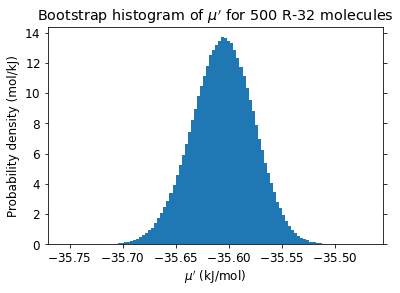

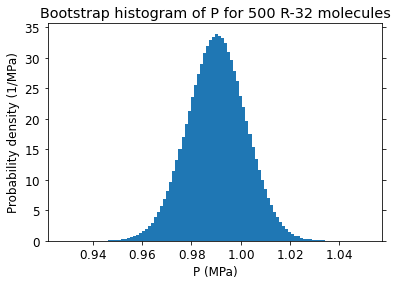

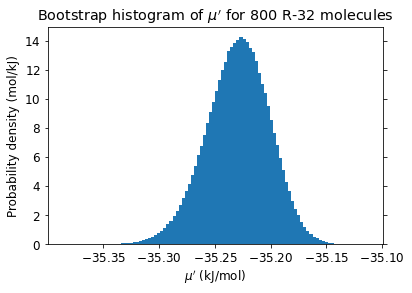

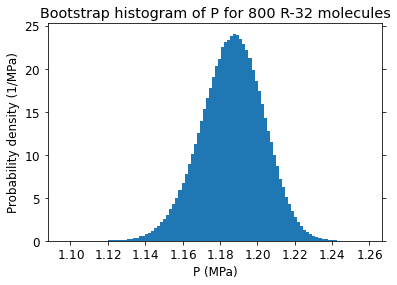

In [78]:
for i, n_solute in enumerate(n_array):
    plt.hist(theta_bs_100sq[:,i,0], bins=100, density=True)
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    plt.show()
    plt.hist(theta_bs_100sq[:,i,1], bins=100, density=True)
    if i:
        theta_variable = "P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.show()

In [79]:
yerr_BCa_100sq = np.abs(CI_BCa_100sq - theta_orig_100sq)
yerr_BCa_P_100sq = yerr_BCa_100sq[...,1:,1]
P_orig_100sq = theta_orig_100sq[...,1:,1]
mu_shift_orig_100sq = theta_orig_100sq[...,0]
yerr_BCa_mu_100sq = yerr_BCa_100sq[...,0]
yerr_BCa_kH_100sq = yerr_BCa_100sq[...,0,1]
kH_orig_100sq = theta_orig_100sq[...,0,1]
yerr_q_100sq = np.abs(CI_percentile_100sq - theta_orig_100sq)
yerr_q_P_100sq = yerr_q_100sq[...,1:,1]
yerr_q_mu_100sq = yerr_q_100sq[...,0]
yerr_q_kH_100sq = yerr_q_100sq[...,0,1]

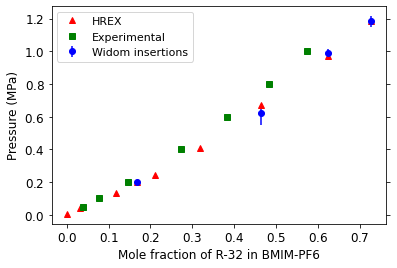

In [80]:
plt.plot(hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.errorbar(xvec[1:], P_orig_100sq, yerr=yerr_BCa_P_100sq, fmt='bo')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
#plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['HREX', 'Experimental', 'Widom insertions'])
plt.show()

In [81]:
yerr_BCa_mu_100sq

array([[0.13072348, 0.11685615, 0.26941487, 0.06253871, 0.06714305],
       [0.10677171, 0.09250276, 0.14358448, 0.05258592, 0.04690034]])

In [82]:
yerr_BCa_mu

array([[0.12765942, 0.11199473, 0.27307459, 0.06269383, 0.06911768],
       [0.10503367, 0.0890081 , 0.1437588 , 0.05189989, 0.04780542]])

In [83]:
yerr_BCa_P_100sq

array([[0.0092984 , 0.07227477, 0.02498245, 0.03911446],
       [0.00765537, 0.03855375, 0.0219543 , 0.02824773]])

In [84]:
yerr_BCa_P

array([[0.00891904, 0.07312935, 0.0250451 , 0.04025538],
       [0.0073615 , 0.0386098 , 0.02165429, 0.02880595]])

In [85]:
yerr_BCa_kH

array([0.05055943, 0.04358387])

In [86]:
yerr_BCa_kH_100sq

array([0.05174373, 0.04432134])

In [87]:
if not all([os.path.exists(p+"_framewise.npy") for p in ("theta_orig", "theta_bs", "CI_percentile", "CI_BCa")]):
    theta_orig_framewise, theta_bs_framewise, CI_percentile_framewise, CI_BCa_framewise = bootstrap(dstack_hcat_wprp2.mean(1),
                                                            statistic_function = statfunc)
    np.save("theta_orig_framewise.npy", theta_orig_framewise)
    np.save("theta_bs_framewise.npy", theta_bs_framewise)
    np.save("CI_percentile_framewise.npy", CI_percentile_framewise)
    np.save("CI_BCa_framewise.npy", CI_BCa_framewise)
else:
    theta_orig_framewise = np.load("theta_orig_framewise.npy")
    theta_bs_framewise = np.load("theta_bs_framewise.npy")
    CI_percentile_framewise = np.load("CI_percentile_framewise.npy")
    CI_BCa_framewise = np.load("CI_BCa_framewise.npy")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


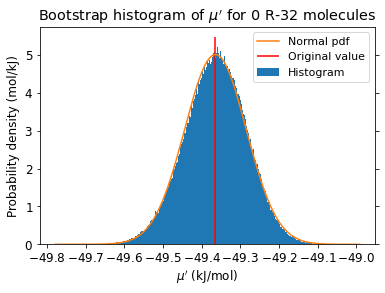

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


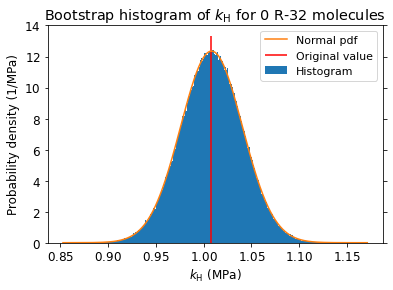

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


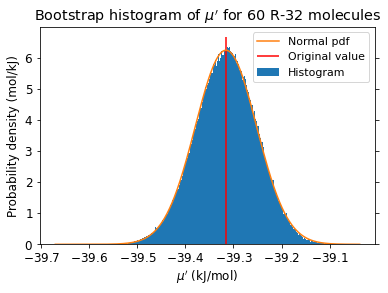

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


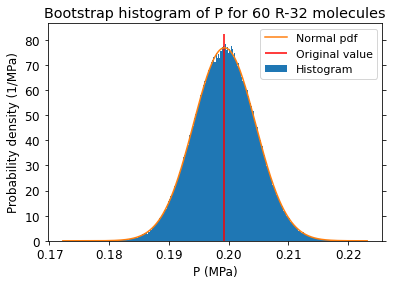

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


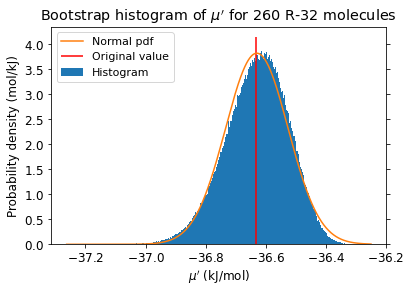

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


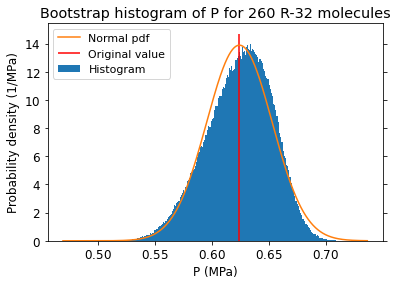

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


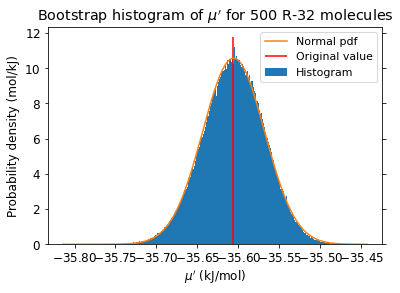

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


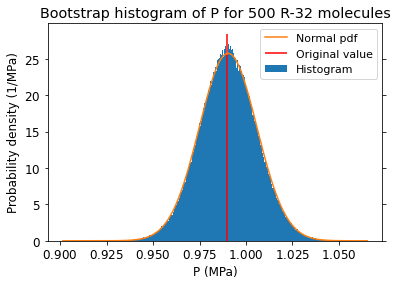

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


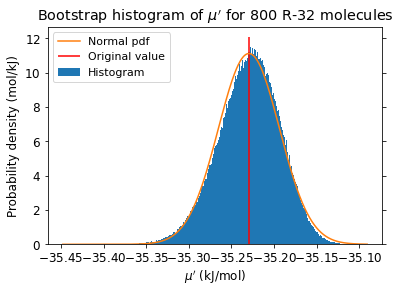

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


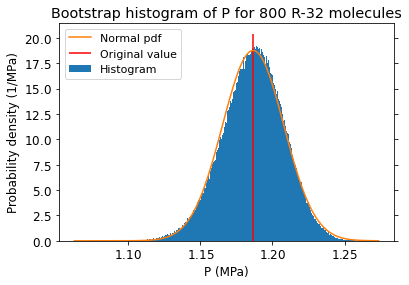

In [88]:
figdir_main = Path("figures", "framewise_bootstrap")
figdir_main_t = Path(figdir_main, "titled")
figdir_main_ut = Path(figdir_main, "untitled")
for i, n_solute in enumerate(n_array):
    figdir_t = Path(figdir_main_t,'n'+str(n_solute))
    figdir_ut = Path(figdir_main_ut,'n'+str(n_solute))
    if not figdir_t.is_dir():
        os.makedirs(figdir_t)
    if not figdir_ut.is_dir():
        os.makedirs(figdir_ut)
    plt.hist(theta_bs_framewise[:,i,0], density=True)
    xvals = np.linspace(theta_bs_framewise[:,i,0].min(), theta_bs_framewise[:,i,0].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_framewise[:,i,0].mean(), scale=theta_bs_framewise[:,i,0].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_framewise[i,0], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    basename = "bh_mu"
    plt.savefig(Path(figdir_ut, basename+'.eps'))
    plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.savefig(Path(figdir_t, basename+'.eps'))
    plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()
    plt.hist(theta_bs_framewise[:,i,1], density=True)
    xvals = np.linspace(theta_bs_framewise[:,i,1].min(), theta_bs_framewise[:,i,1].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_framewise[:,i,1].mean(), scale=theta_bs_framewise[:,i,1].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_framewise[i,1], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    if i:
        theta_variable = "P"
        basename = "bh_P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
        basename = "bh_kH"
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.savefig(Path(figdir_ut, basename+'.eps'))
    plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.savefig(Path(figdir_t, basename+'.eps'))
    plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()

In [89]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [90]:
yerr_BCa_framewise = np.abs(CI_BCa_framewise - theta_orig_framewise)
yerr_BCa_P_framewise = yerr_BCa_framewise[...,1:,1]
kH_orig_framewise = theta_orig_framewise[...,0,1]
P_orig_framewise = theta_orig_framewise[...,1:,1]
mu_shift_orig_framewise = theta_orig_framewise[...,0]
yerr_BCa_mu_framewise = yerr_BCa_framewise[...,0]
yerr_BCa_kH_framewise = yerr_BCa_framewise[...,0,1]
kH_orig_framewise = theta_orig_framewise[...,0,1]
yerr_q_framewise = np.abs(CI_percentile_framewise - theta_orig_framewise)
yerr_q_P_framewise = yerr_q_framewise[...,1:,1]
yerr_q_mu_framewise = yerr_q_framewise[...,0]
yerr_q_kH_framewise = yerr_q_framewise[...,0,1]

In [91]:
yerr_q_P_framewise

array([[0.01003267, 0.05981722, 0.03014589, 0.04324205],
       [0.01030649, 0.05049431, 0.03090614, 0.04025391]])

In [92]:
yerr_BCa_P_framewise

array([[0.01082191, 0.07474196, 0.03232782, 0.05134248],
       [0.00958402, 0.04240256, 0.02890875, 0.03511393]])

In [93]:
yerr_BCa_kH_framewise

array([0.07013934, 0.05759337])

In [94]:
yerr_q_kH_framewise

array([0.06271298, 0.06390457])

In [95]:
yerr_BCa_mu_framewise

array([[0.1788315 , 0.13652078, 0.2799534 , 0.08063247, 0.08821332],
       [0.13790735, 0.11527903, 0.15857395, 0.06829725, 0.05799219]])

In [96]:
beta.to_value('mol/kJ')

0.4033954783765918

In [97]:
def statfunc_n0(bs):
    nst = bs.shape[:-1]
    theta = np.zeros(nst+(1,2))
    theta[...,0] = mushift(bs)
    theta[...,0,1] = (u.kb * T * density[0] * np.exp((theta[...,0,0] - mu_ig[0])*beta.to_value('mol/kJ'))).to_value('MPa')

In [98]:
def statfunc_perftest(bs):
#     print(bs.shape)
#     nst = bs.shape[:-1]
    theta = np.zeros(bs.shape+(2,))
    theta[...,0] = mushift(bs)
    theta[...,1] = (u.kb * T * density[0] * np.exp((theta[...,0] - mu_ig[0])*beta.to_value('mol/kJ'))).to_value('MPa')
    return theta

In [99]:
wprp2_maxkBT_10_full = np.loadtxt('performance_test/maxkBT_10_full/cas_widom.out.spec3.wprp2')

In [100]:
wprp2_maxkBT_50_full = np.loadtxt('performance_test/maxkBT_50_full/cas_widom.out.spec3.wprp2')

In [101]:
wprp2_maxkBT_708_full = np.loadtxt('performance_test/maxkBT_708_full/cas_widom.out.spec3.wprp2')

In [102]:
dstack_perftest_wprp2 = np.dstack([np.loadtxt(f'performance_test/maxkBT_{mkbt}_full/cas_widom.out.spec3.wprp2') for mkbt in [10,50,708]])

In [103]:
dstack_perftest_wprp2.mean(1).shape

(50000, 3)

In [104]:
if not all([os.path.exists(p+"_hor_pt.npy") for p in ("theta_orig", "theta_bs", "CI_percentile", "CI_BCa")]):
    theta_orig_hor_pt, theta_bs_hor_pt, CI_percentile_hor_pt, CI_BCa_hor_pt = bootstrap(dstack_perftest_wprp2.mean(0),
                                                            statistic_function = statfunc_perftest)
    np.save("theta_orig_hor_pt.npy", theta_orig_hor_pt)
    np.save("theta_bs_hor_pt.npy", theta_bs_hor_pt)
    np.save("CI_percentile_hor_pt.npy", CI_percentile_hor_pt)
    np.save("CI_BCa_hor_pt.npy", CI_BCa_hor_pt)
else:
    theta_orig_hor_pt = np.load("theta_orig_hor_pt.npy")
    theta_bs_hor_pt = np.load("theta_bs_hor_pt.npy")
    CI_percentile_hor_pt = np.load("CI_percentile_hor_pt.npy")
    CI_BCa_hor_pt = np.load("CI_BCa_hor_pt.npy")

In [105]:
theta_orig_hor_pt

array([[-49.1043813 ,   1.11912829],
       [-49.1755572 ,   1.08745275],
       [-49.01459445,   1.16040569]])

In [106]:
CI_percentile_hor_pt

array([[[-49.51264283,   0.94919522],
        [-49.48156756,   0.96116887],
        [-49.38416631,   0.99968611]],

       [[-48.75851138,   1.28668923],
        [-48.86737308,   1.23140786],
        [-48.68303824,   1.32646559]]])

In [107]:
CI_BCa_hor_pt

array([[[-49.69418691,   0.88086561],
        [-49.52357191,   0.94487654],
        [-49.50978866,   0.94937398]],

       [[-48.82885093,   1.25030589],
        [-48.9008823 ,   1.2147485 ],
        [-48.74461098,   1.29355882]]])

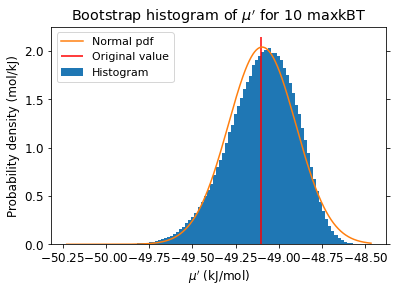

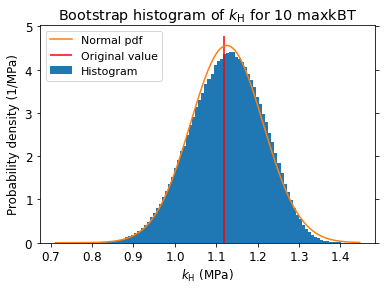

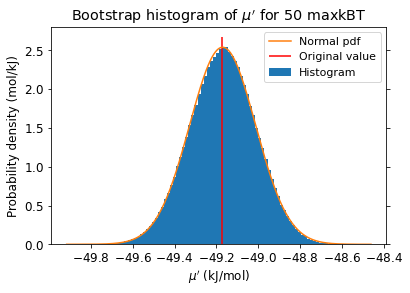

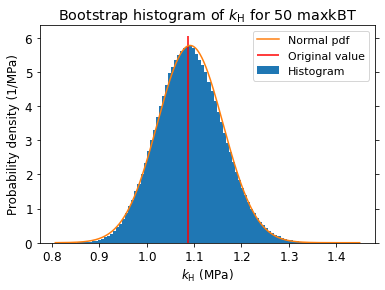

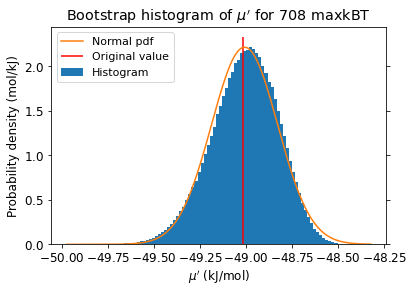

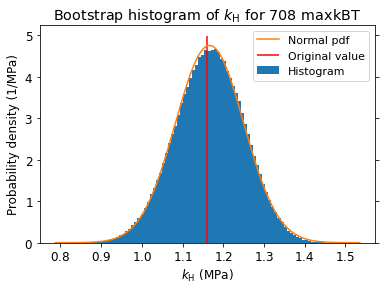

In [108]:
# figdir_main = Path("figures", "hor_pt_bootstrap")
# figdir_main_t = Path(figdir_main, "titled")
# figdir_main_ut = Path(figdir_main, "untitled")
for i, mkbt in enumerate([10,50,708]):
#     figdir_t = Path(figdir_main_t,'n'+str(n_solute))
#     figdir_ut = Path(figdir_main_ut,'n'+str(n_solute))
#     if not figdir_t.is_dir():
#         os.makedirs(figdir_t)
#     if not figdir_ut.is_dir():
#         os.makedirs(figdir_ut)
    plt.hist(theta_bs_hor_pt[:,i,0], bins=100, density=True)
    xvals = np.linspace(theta_bs_hor_pt[:,i,0].min(), theta_bs_hor_pt[:,i,0].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_hor_pt[:,i,0].mean(), scale=theta_bs_hor_pt[:,i,0].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_hor_pt[i,0], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    basename = "bh_mu"
#     plt.savefig(Path(figdir_ut, basename+'.eps'))
#     plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(mkbt)+" maxkBT")
#     plt.savefig(Path(figdir_t, basename+'.eps'))
#     plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()
    plt.hist(theta_bs_hor_pt[:,i,1], bins=100, density=True)
    xvals = np.linspace(theta_bs_hor_pt[:,i,1].min(), theta_bs_hor_pt[:,i,1].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_hor_pt[:,i,1].mean(), scale=theta_bs_hor_pt[:,i,1].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_hor_pt[i,1], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    theta_variable = r"$k_\mathrm{H}$"
    basename = "bh_kH"
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
#     plt.savefig(Path(figdir_ut, basename+'.eps'))
#     plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(mkbt)+" maxkBT")
#     plt.savefig(Path(figdir_t, basename+'.eps'))
#     plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()

In [109]:
if not all([os.path.exists(p+"_vert_pt.npy") for p in ("theta_orig", "theta_bs", "CI_percentile", "CI_BCa")]):
    theta_orig_vert_pt, theta_bs_vert_pt, CI_percentile_vert_pt, CI_BCa_vert_pt = bootstrap(dstack_perftest_wprp2.mean(1),
                                                            statistic_function = statfunc_perftest)
    np.save("theta_orig_vert_pt.npy", theta_orig_vert_pt)
    np.save("theta_bs_vert_pt.npy", theta_bs_vert_pt)
    np.save("CI_percentile_vert_pt.npy", CI_percentile_vert_pt)
    np.save("CI_BCa_vert_pt.npy", CI_BCa_vert_pt)
else:
    theta_orig_vert_pt = np.load("theta_orig_vert_pt.npy")
    theta_bs_vert_pt = np.load("theta_bs_vert_pt.npy")
    CI_percentile_vert_pt = np.load("CI_percentile_vert_pt.npy")
    CI_BCa_vert_pt = np.load("CI_BCa_vert_pt.npy")

In [110]:
theta_orig_vert_pt

array([[-49.1043813 ,   1.11912829],
       [-49.1755572 ,   1.08745275],
       [-49.01459445,   1.16040569]])

In [111]:
CI_percentile_vert_pt

array([[[-49.54688893,   0.93617252],
        [-49.45094522,   0.97311574],
        [-49.34625977,   1.01509011]],

       [[-48.71861585,   1.30756432],
        [-48.89570526,   1.21741413],
        [-48.69486463,   1.32015248]]])

In [112]:
CI_BCa_vert_pt

array([[[-49.74056422,   0.86445523],
        [-49.48183499,   0.96102768],
        [-49.41411308,   0.98736107]],

       [[-48.79773634,   1.26601675],
        [-48.92201503,   1.20453247],
        [-48.74018294,   1.29603471]]])

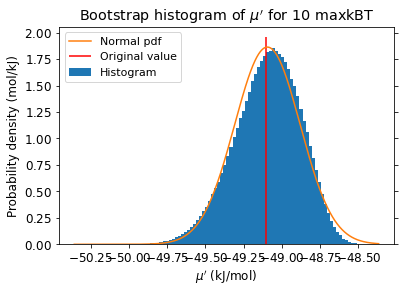

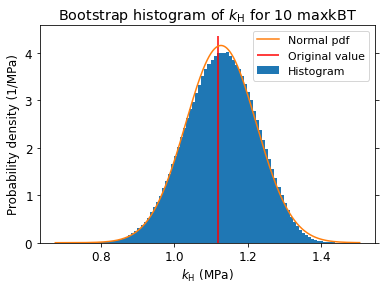

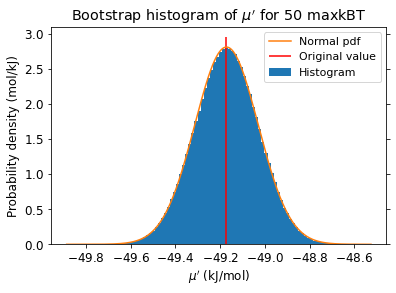

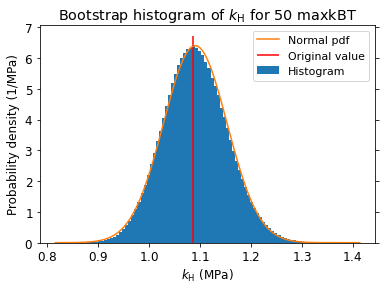

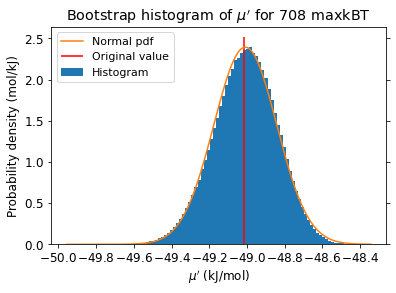

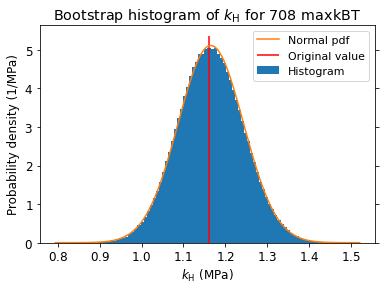

In [113]:
# figdir_main = Path("figures", "vert_pt_bootstrap")
# figdir_main_t = Path(figdir_main, "titled")
# figdir_main_ut = Path(figdir_main, "untitled")
for i, mkbt in enumerate([10,50,708]):
#     figdir_t = Path(figdir_main_t,'n'+str(n_solute))
#     figdir_ut = Path(figdir_main_ut,'n'+str(n_solute))
#     if not figdir_t.is_dir():
#         os.makedirs(figdir_t)
#     if not figdir_ut.is_dir():
#         os.makedirs(figdir_ut)
    plt.hist(theta_bs_vert_pt[:,i,0], bins=100, density=True)
    xvals = np.linspace(theta_bs_vert_pt[:,i,0].min(), theta_bs_vert_pt[:,i,0].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_vert_pt[:,i,0].mean(), scale=theta_bs_vert_pt[:,i,0].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_vert_pt[i,0], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    basename = "bh_mu"
#     plt.savefig(Path(figdir_ut, basename+'.eps'))
#     plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(mkbt)+" maxkBT")
#     plt.savefig(Path(figdir_t, basename+'.eps'))
#     plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()
    plt.hist(theta_bs_vert_pt[:,i,1], bins=100, density=True)
    xvals = np.linspace(theta_bs_vert_pt[:,i,1].min(), theta_bs_vert_pt[:,i,1].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_vert_pt[:,i,1].mean(), scale=theta_bs_vert_pt[:,i,1].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_vert_pt[i,1], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Normal pdf', 'Original value', 'Histogram'])
    theta_variable = r"$k_\mathrm{H}$"
    basename = "bh_kH"
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
#     plt.savefig(Path(figdir_ut, basename+'.eps'))
#     plt.savefig(Path(figdir_ut, basename+'.png'))
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(mkbt)+" maxkBT")
#     plt.savefig(Path(figdir_t, basename+'.eps'))
#     plt.savefig(Path(figdir_t, basename+'.png'))
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


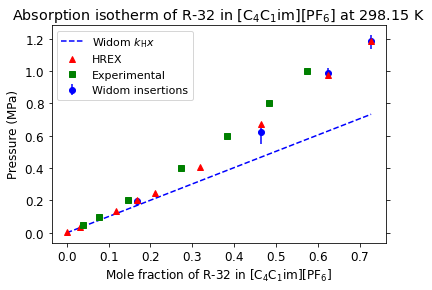

In [132]:

plt.errorbar(xvec[1:], P_orig_framewise, yerr=yerr_BCa_P_framewise, fmt='bo', barsabove=True)
plt.plot([0, xvec[-1]], [0, xvec[-1]*kH_orig_framewise], 'b--',
         hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.xlabel(r'Mole fraction of R-32 in $\mathrm{[C_4C_1im][PF_6]}$')
plt.ylabel('Pressure (MPa)')
plt.legend([r"Widom $k_\mathrm{H}x$", 'HREX', 'Experimental', 'Widom insertions'])
basename = "r32_bmim-pf6_isotherm"
plt.savefig(Path(figdir_main_ut, basename+'.eps'))
plt.savefig(Path(figdir_main_ut, basename+'.png'))
plt.title(r'Absorption isotherm of R-32 in $\mathrm{[C_4C_1im][PF_6]}$ at 298.15 K')
plt.savefig(Path(figdir_main_t, basename+'.eps'))
plt.savefig(Path(figdir_main_t, basename+'.png'))
plt.show()

In [115]:
yerr_BCa_mu_framewise

array([[0.1788315 , 0.13652078, 0.2799534 , 0.08063247, 0.08821332],
       [0.13790735, 0.11527903, 0.15857395, 0.06829725, 0.05799219]])

In [116]:
yerr_BCa_mu

array([[0.12765942, 0.11199473, 0.27307459, 0.06269383, 0.06911768],
       [0.10503367, 0.0890081 , 0.1437588 , 0.05189989, 0.04780542]])

In [117]:
yerr_BCa_P_100sq

array([[0.0092984 , 0.07227477, 0.02498245, 0.03911446],
       [0.00765537, 0.03855375, 0.0219543 , 0.02824773]])

In [118]:
yerr_BCa_P_framewise

array([[0.01082191, 0.07474196, 0.03232782, 0.05134248],
       [0.00958402, 0.04240256, 0.02890875, 0.03511393]])

In [119]:
yerr_BCa_P

array([[0.00891904, 0.07312935, 0.0250451 , 0.04025538],
       [0.0073615 , 0.0386098 , 0.02165429, 0.02880595]])

In [120]:
yerr_BCa_kH

array([0.05055943, 0.04358387])

In [121]:
yerr_BCa_kH_100sq

array([0.05174373, 0.04432134])

In [122]:
yerr_BCa_kH_framewise

array([0.07013934, 0.05759337])

In [123]:
CI_BCa_framewise[...,1:,1]

array([[0.18837795, 0.54919106, 0.95767825, 1.13484815],
       [0.20878388, 0.66633558, 1.01891482, 1.22130456]])

In [124]:
hrex_df.P_MPa

0    0.005
1    0.039
2    0.134
3    0.202
4    0.246
5    0.409
6    0.671
7    0.973
8    1.186
Name: P_MPa, dtype: float64

In [125]:
hrex_df

,x_molfraction,P_MPa
0,0.000,0.005
1,0.032,0.039
2,0.118,0.134
3,0.167,0.202
4,0.211,0.246
5,0.318,0.409
6,0.464,0.671
7,0.625,0.973
8,0.727,1.186


In [126]:
dstack_hcat_wprp2_s1 = np.load("scheme1/dstack_hcat_wprp2.npy")

In [127]:
if not all([os.path.exists(p+".npy") for p in ("theta_orig_s1", "theta_bs_s1", "CI_percentile_s1", "CI_BCa_s1")]):
    theta_orig_s1, theta_bs_s1, CI_percentile_s1, CI_BCa_s1 = bootstrap(dstack_hcat_wprp2_s1.mean(0),
                                                            statistic_function = statfunc)
    np.save("theta_orig_s1.npy", theta_orig)
    np.save("theta_bs_s1.npy", theta_bs)
    np.save("CI_percentile_s1.npy", CI_percentile)
    np.save("CI_BCa.npy_s1", CI_BCa)
else:
    theta_orig_s1 = np.load("theta_orig_s1.npy")
    theta_bs_s1 = np.load("theta_bs_s1.npy")
    CI_percentile_s1 = np.load("CI_percentile_s1.npy")
    CI_BCa_s1 = np.load("CI_BCa_s1.npy")

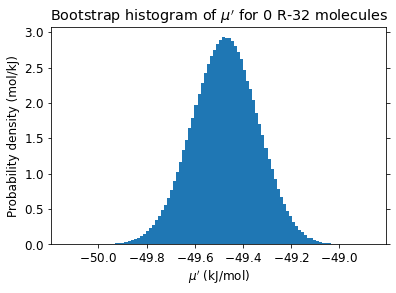

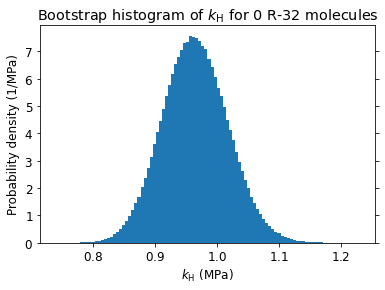

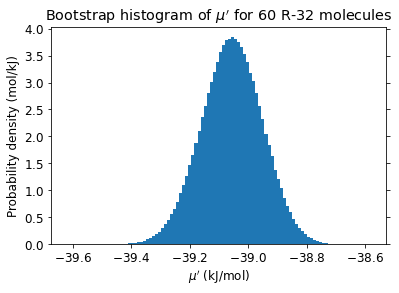

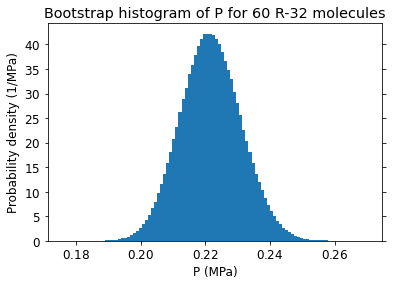

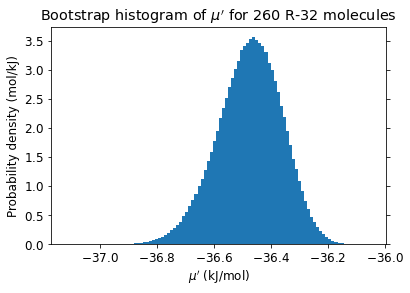

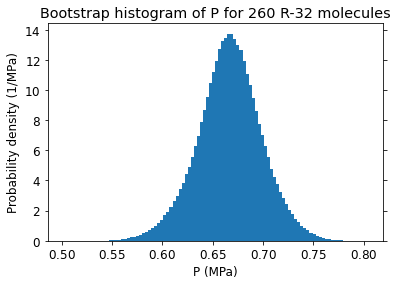

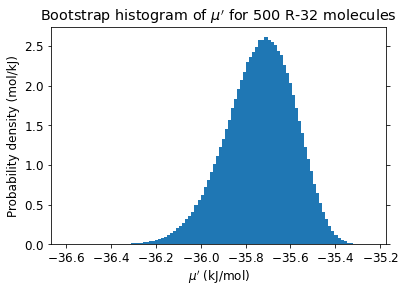

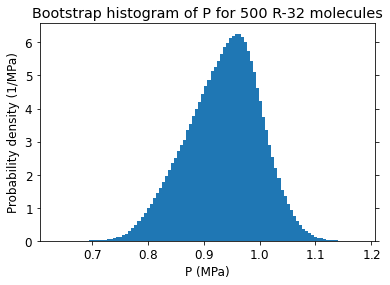

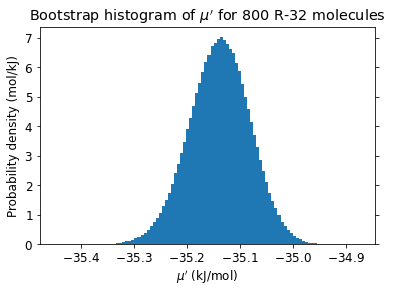

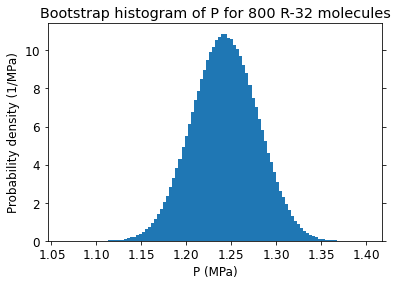

In [128]:
for i, n_solute in enumerate(n_array):
    plt.hist(theta_bs_s1[:,i,0], bins=100, density=True)
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    plt.show()
    plt.hist(theta_bs_s1[:,i,1], bins=100, density=True)
    if i:
        theta_variable = "P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.show()
yerr_BCa_s1 = np.abs(CI_BCa_s1 - theta_orig_s1)
yerr_BCa_P_s1 = yerr_BCa_s1[...,1:,1]
P_orig_s1 = theta_orig_s1[...,1:,1]
mu_shift_orig_s1 = theta_orig_s1[...,0]
yerr_BCa_mu_s1 = yerr_BCa_s1[...,0]
yerr_BCa_kH_s1 = yerr_BCa_s1[...,0,1]
kH_orig_s1 = theta_orig_s1[...,0,1]
yerr_q_s1 = np.abs(CI_percentile_s1 - theta_orig_s1)
yerr_q_P_s1 = yerr_q_s1[...,1:,1]
yerr_q_mu_s1 = yerr_q_s1[...,0]
yerr_q_kH_s1 = yerr_q_s1[...,0,1]

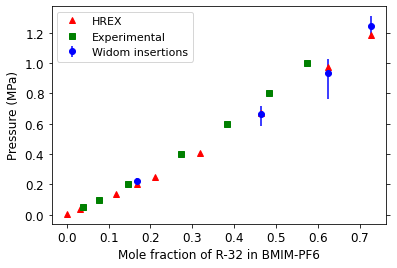

In [129]:
plt.plot(hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.errorbar(xvec[1:], P_orig_s1, yerr=yerr_BCa_P_s1, fmt='bo')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
#plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['HREX', 'Experimental', 'Widom insertions'])
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


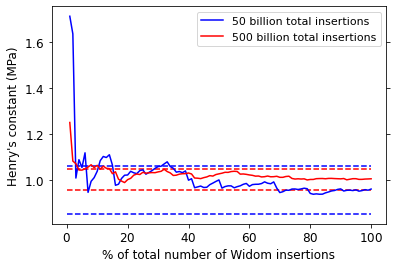

In [130]:
plt.figure()
plt.plot(np.arange(100)+1,np.loadtxt('scheme1/H_convergence.txt'), 'b-',np.arange(100)+1,np.loadtxt('scheme2/H_convergence.txt'),'r-')
plt.hlines(CI_BCa_s1[...,0,1], xmin=0.0, xmax=100.0, colors='b', linestyles='dashed')
plt.hlines(CI_BCa[...,0,1], xmin=0.0, xmax=100.0, colors='r', linestyles='dashed')
#plt.title("Convergence of Henry's constant of R-32 in BMIM-PF6")
plt.legend(['50 billion total insertions', '500 billion total insertions'])
plt.ylabel("Henry's constant (MPa)")
plt.xlabel('% of total number of Widom insertions')
plt.tick_params(which='both', right=True)
#plt.tick_params(labelright=True)
plt.savefig("kH_vs_percent_insertions.eps")
plt.savefig("kH_vs_percent_insertions.png")

In [103]:
rng = default_rng()
rng.shuffle(dstack_hcat_wprp2, axis=0)

In [104]:
theta_orig_sb, theta_bs_sb, CI_percentile_sb, CI_BCa_sb = bootstrap(np.reshape(block_avg(block_avg(dstack_hcat_wprp2, 100, 0), 100, 1), (10000,5)),
                                                        statistic_function = statfunc)
yerr_BCa_sb = np.abs(CI_BCa_sb - theta_orig_sb)
yerr_BCa_P_sb = yerr_BCa_sb[...,1:,1]
P_orig_sb = theta_orig_sb[...,1:,1]
mu_shift_orig_sb = theta_orig_sb[...,0]
yerr_BCa_mu_sb = yerr_BCa_sb[...,0]
yerr_BCa_kH_sb = yerr_BCa_sb[...,0,1]
kH_orig_sb = theta_orig_sb[...,0,1]
yerr_q_sb = np.abs(CI_percentile_sb - theta_orig_sb)
yerr_q_P_sb = yerr_q_sb[...,1:,1]
yerr_q_mu_sb = yerr_q_sb[...,0]
yerr_q_kH_sb = yerr_q_sb[...,0,1]

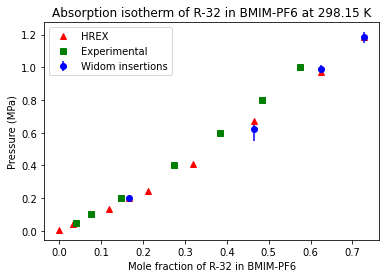

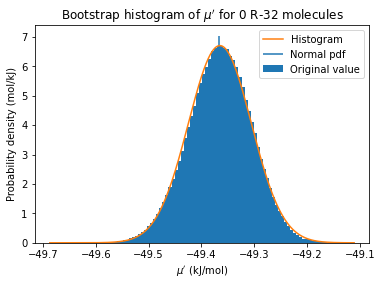

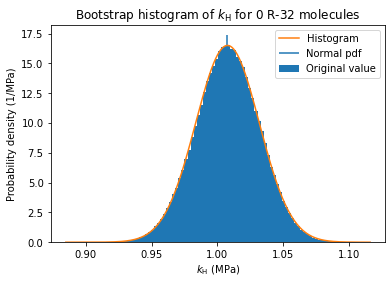

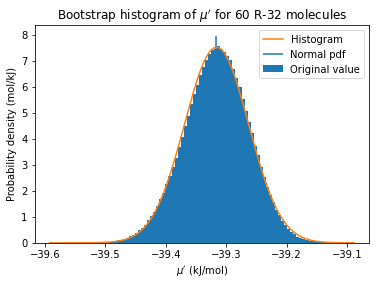

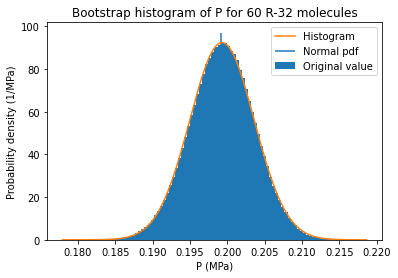

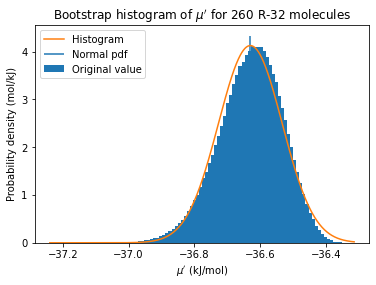

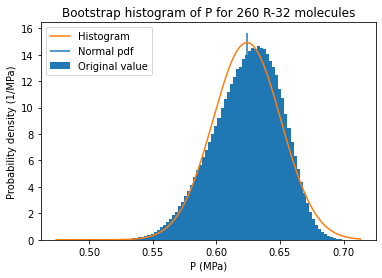

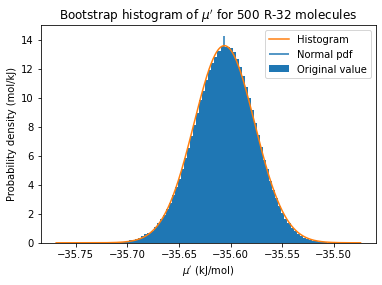

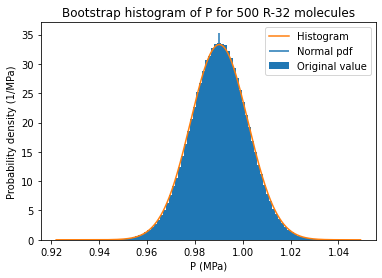

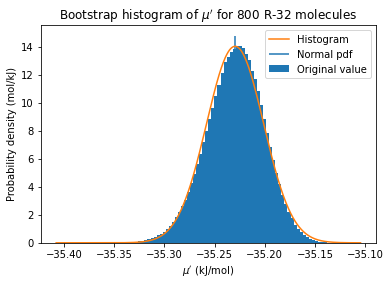

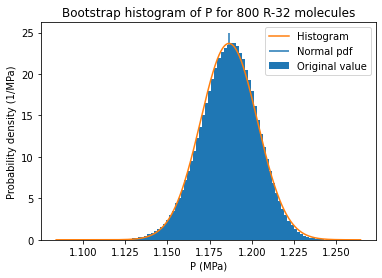

In [105]:

plt.plot(hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.errorbar(xvec[1:], P_orig_sb, yerr=yerr_BCa_P_sb, fmt='bo')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['HREX', 'Experimental', 'Widom insertions'])
plt.show()
for i, n_solute in enumerate(n_array):
    plt.hist(theta_bs_sb[:,i,0], bins=100, density=True)
    xvals = np.linspace(theta_bs_sb[:,i,0].min(), theta_bs_sb[:,i,0].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_sb[:,i,0].mean(), scale=theta_bs_sb[:,i,0].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_sb[i,0], ymin=ylims[0], ymax=ylims[1])
    plt.legend(['Histogram', 'Normal pdf', 'Original value'])
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    plt.show()
    plt.hist(theta_bs_sb[:,i,1], bins=100, density=True)
    xvals = np.linspace(theta_bs_sb[:,i,1].min(), theta_bs_sb[:,i,1].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_sb[:,i,1].mean(), scale=theta_bs_sb[:,i,1].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_sb[i,1], ymin=ylims[0], ymax=ylims[1])
    plt.legend(['Histogram', 'Normal pdf', 'Original value'])
    if i:
        theta_variable = "P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.show()

In [106]:
theta_orig_fs, theta_bs_fs, CI_percentile_fs, CI_BCa_fs = bootstrap(dstack_hcat_wprp2.mean(1),
                                                        statistic_function = statfunc)
yerr_BCa_fs = np.abs(CI_BCa_fs - theta_orig_fs)
yerr_BCa_P_fs = yerr_BCa_fs[...,1:,1]
P_orig_fs = theta_orig_fs[...,1:,1]
mu_shift_orig_fs = theta_orig_fs[...,0]
yerr_BCa_mu_fs = yerr_BCa_fs[...,0]
yerr_BCa_kH_fs = yerr_BCa_fs[...,0,1]
kH_orig_fs = theta_orig_fs[...,0,1]
yerr_q_fs = np.abs(CI_percentile_fs - theta_orig_fs)
yerr_q_P_fs = yerr_q_fs[...,1:,1]
yerr_q_mu_fs = yerr_q_fs[...,0]
yerr_q_kH_fs = yerr_q_fs[...,0,1]

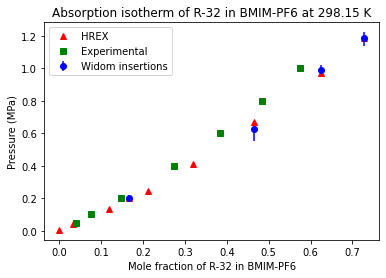

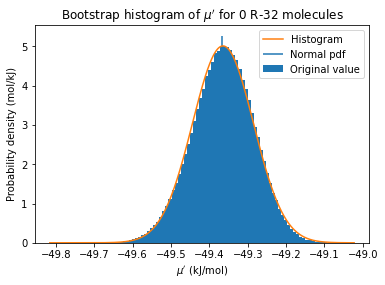

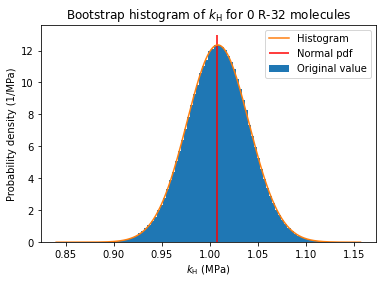

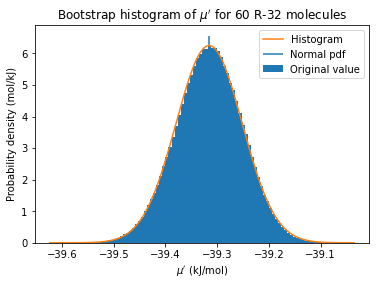

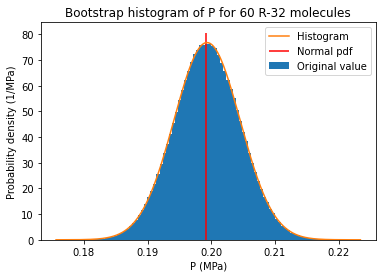

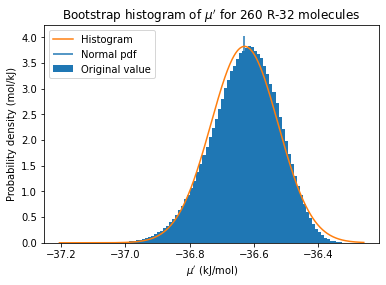

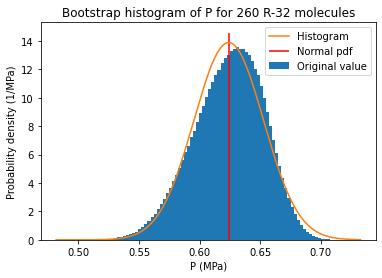

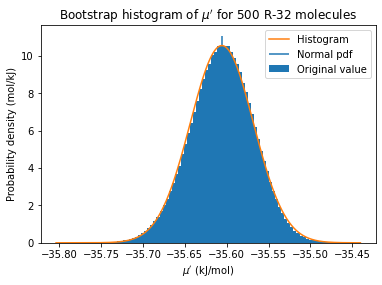

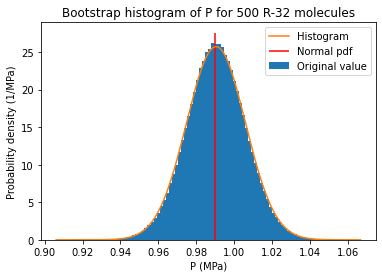

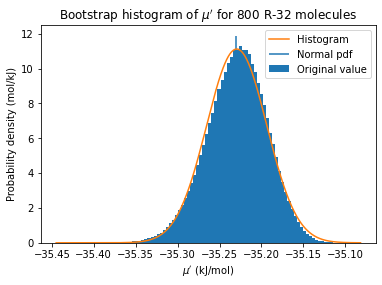

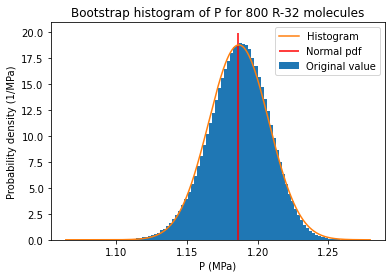

In [107]:
plt.plot(hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.errorbar(xvec[1:], P_orig_fs, yerr=yerr_BCa_P_fs, fmt='bo')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['HREX', 'Experimental', 'Widom insertions'])
plt.show()
for i, n_solute in enumerate(n_array):
    plt.hist(theta_bs_fs[:,i,0], bins=100, density=True)
    xvals = np.linspace(theta_bs_fs[:,i,0].min(), theta_bs_fs[:,i,0].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_fs[:,i,0].mean(), scale=theta_bs_fs[:,i,0].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_fs[i,0], ymin=ylims[0], ymax=ylims[1])
    plt.legend(['Histogram', 'Normal pdf', 'Original value'])
    plt.title(r"Bootstrap histogram of $\mu'$ for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(r"$\mu'$ (kJ/mol)")
    plt.ylabel("Probability density (mol/kJ)")
    plt.show()
    plt.hist(theta_bs_fs[:,i,1], bins=100, density=True)
    xvals = np.linspace(theta_bs_fs[:,i,1].min(), theta_bs_fs[:,i,1].max(), 1000)
    plt.plot(xvals, scipy.stats.norm.pdf(xvals, loc=theta_bs_fs[:,i,1].mean(), scale=theta_bs_fs[:,i,1].std()))
    ylims = plt.ylim()
    plt.vlines(theta_orig_fs[i,1], ymin=ylims[0], ymax=ylims[1], colors='r')
    plt.legend(['Histogram', 'Normal pdf', 'Original value'])
    if i:
        theta_variable = "P"
    else:
        theta_variable = r"$k_\mathrm{H}$"
    plt.title("Bootstrap histogram of "+theta_variable+" for "+str(n_solute)+" R-32 molecules")
    plt.xlabel(theta_variable+" (MPa)")
    plt.ylabel("Probability density (1/MPa)")
    plt.show()

In [108]:
yerr_BCa_mu

array([[0.12828253, 0.1123682 , 0.2719974 , 0.06278228, 0.06936993],
       [0.10508329, 0.08915423, 0.14412731, 0.05162916, 0.04771221]])

In [109]:
yerr_BCa_mu_100sq

array([[0.13070497, 0.1164581 , 0.26833615, 0.06272634, 0.06678646],
       [0.10697071, 0.0921003 , 0.14370565, 0.05252646, 0.04708919]])

In [110]:
yerr_BCa_mu_framewise

array([[0.17830861, 0.13653524, 0.27947251, 0.08065189, 0.08840914],
       [0.13829125, 0.1153275 , 0.15870579, 0.06842067, 0.05812369]])

In [111]:
yerr_BCa_mu_sb

array([[0.13019895, 0.11738158, 0.26915899, 0.06301678, 0.06767739],
       [0.10570363, 0.09344996, 0.14352402, 0.0529745 , 0.04708262]])

In [112]:
yerr_BCa_mu_fs

array([[0.17846532, 0.13647055, 0.27909665, 0.08105737, 0.08793155],
       [0.13821533, 0.11572938, 0.15869047, 0.06807817, 0.05810384]])

In [113]:
yerr_BCa_P

array([[0.00894816, 0.07287945, 0.02508247, 0.04040452],
       [0.00737368, 0.03870475, 0.02153749, 0.02874683]])

In [114]:
yerr_BCa_P_100sq

array([[0.00926684, 0.07202916, 0.02505897, 0.03890875],
       [0.00762134, 0.03858758, 0.02192757, 0.02836339]])

In [115]:
yerr_BCa_P_framewise

array([[0.01082289, 0.07466997, 0.03233764, 0.05145264],
       [0.0095883 , 0.04243835, 0.02896437, 0.03519274]])

In [116]:
yerr_BCa_P_sb

array([[0.00933873, 0.07220481, 0.02517409, 0.0394238 ],
       [0.00773532, 0.03853685, 0.02212304, 0.02835876]])

In [117]:
yerr_BCa_P_fs

array([[0.01081859, 0.07450788, 0.03250114, 0.05117433],
       [0.0096225 , 0.04243668, 0.02881241, 0.0351847 ]])

In [118]:
yerr_BCa_kH

array([0.05079884, 0.04360484])

In [119]:
yerr_BCa_kH_100sq

array([0.05173863, 0.04440607])

In [120]:
yerr_BCa_kH_framewise

array([0.06993162, 0.0577518 ])

In [121]:
yerr_BCa_kH_sb

array([0.0515379 , 0.04386771])

In [122]:
yerr_BCa_kH_fs

array([0.06999667, 0.05771943])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


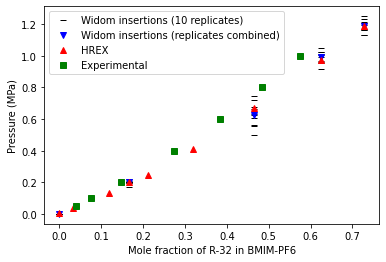

In [28]:
#plt.figure()
plt.plot(xvec_multirep, P_s2_multirep, 'k_',
         xvec, P_s2, 'bv',
         hrex_df.x_molfraction, hrex_df.P_MPa, 'r^',
         x_exp, P_exp, 'gs',
        )
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
#plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.legend(['Widom insertions (10 replicates)','Widom insertions (replicates combined)', 'HREX', 'Experimental'])
plt.savefig("r32_Pvx.eps")
plt.show()

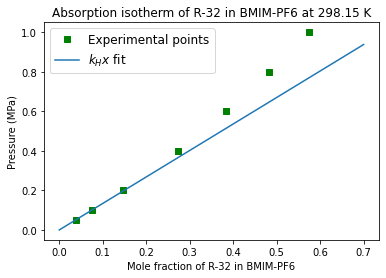

In [31]:
plt.plot(x_exp, P_exp, 'gs',
         [0,0.7],[0,0.7*1.34],
        )
plt.title('Absorption isotherm of R-32 in BMIM-PF6 at 298.15 K')
plt.xlabel('Mole fraction of R-32 in BMIM-PF6')
plt.ylabel('Pressure (MPa)')
plt.legend(["Experimental points", r"$k_H x$ fit"], fontsize=12)
plt.show()

In [29]:
P_s2[1]/xvec[1]

1.1951992675203487

In [30]:
np.loadtxt('scheme2/H_convergence.txt')[-1]

1.007145

In [62]:
def widom_analysis(widomarray, T, maxsep=5, printmu=False):
    N = len(widomarray)
    if printmu:
        sub_N = int(N/3)
        sub_wmeans = np.array([np.mean(widomarray[:sub_N]), np.mean(widomarray[sub_N:2*sub_N]), np.mean(widomarray[2*sub_N:3*sub_N])])
        submu = -u.kb*T*np.log(sub_wmeans) # sub-run mu' values in kJ/mol
        submu_stderr = stat.stdev(submu) # standard error of sub-run mu'
        mu = -u.kb*T*np.log(np.mean(widomarray)) # overall estimate of mu' in kJ/mol
        f_stderr = '{:.0e}'.format(submu_stderr)
        mu_precision = f_stderr[3:]
        formatted_mu_string = ('The shifted chemical potential is {:.'+mu_precision+'f}('+f_stderr[0]+') kJ/mol').format(mu)
        print(formatted_mu_string)
        if not ('-' in f_stderr or mu_precision == '00'):
            print("Error is actually ", submu_stderr)
    stepmu = -u.kb*T*np.log(widomarray)
    stepmu_shiftmat = np.zeros((maxsep+1, N-maxsep))
    stepwvar_shiftmat = np.zeros((maxsep+1, N-maxsep))
    for i in range(maxsep+1):
        stepmu_shiftmat[i] = stepmu[i:(N-maxsep+i)]
        stepwvar_shiftmat[i] = widomarray[i:(N-maxsep+i)]
    Rmat_mu = np.corrcoef(stepmu_shiftmat)
    Rvec_mu = Rmat_mu[0]
    Rmat_wvar = np.corrcoef(stepwvar_shiftmat)
    Rvec_wvar = Rmat_wvar[0]
    df_R = pd.DataFrame({"R_mu": Rvec_mu, "R_wvar": Rvec_wvar})
    return df_R, stepmu

In [63]:
wprp = np.loadtxt("scheme2/n0/wprp.txt")

In [64]:
widom_array = np.mean(wprp,1)

In [65]:
T = 298.15 * u.K

In [66]:
df_R, stepmu = widom_analysis(widom_array,T,maxsep=10000)

<Figure size 432x288 with 0 Axes>

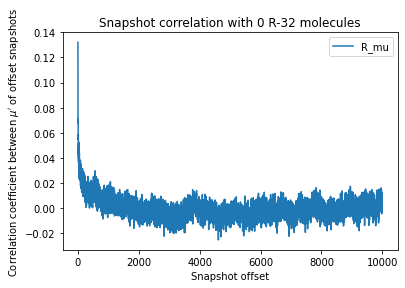

In [67]:
plt.figure(1)
df_R[1:].plot(y='R_mu')
plt.xlabel('Snapshot offset')
plt.ylabel("Correlation coefficient between $\mu'$ of offset snapshots")
plt.title("Snapshot correlation with 0 R-32 molecules")
plt.show()

In [68]:
mu_p_array = np.percentile(stepmu,[0, 1, 10, 50, 100])
mu_p_array

array([-1.09392293e-19, -9.26879998e-20, -8.41441422e-20, -7.35315221e-20,
       -2.11324388e-20])

In [69]:
widom_p_array = np.percentile(widom_array, [0, 50, 90, 99, 100])
widom_p_array

array([1.69645847e+02, 5.72561851e+07, 7.54205090e+08, 6.01028584e+09,
       3.47739586e+11])

Text(0, 0.5, 'Fraction of widom_var sum under this percentile')

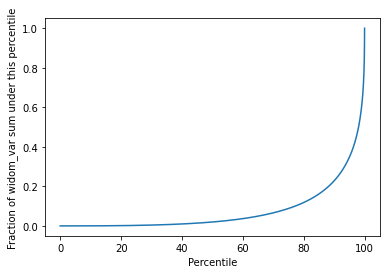

In [70]:
p_axis = np.flip(np.linspace(100.0, 0.0, num=len(widom_array), endpoint=False))
csum = np.cumsum(np.sort(widom_array))
plt.figure()
plt.plot(p_axis, csum/csum[-1])
plt.xlabel('Percentile')
plt.ylabel('Fraction of widom_var sum under this percentile')

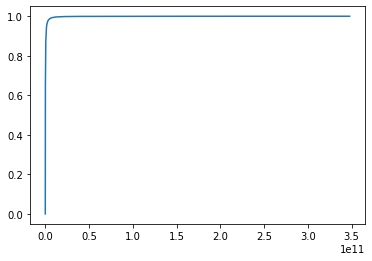

In [71]:
wsort = np.sort(widom_array)
np_axis = p_axis*0.01
plt.figure()
plt.plot(wsort, np_axis)

In [72]:
max(p_axis)

100.0

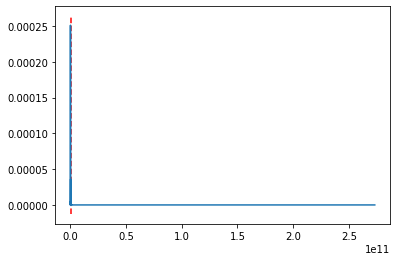

In [73]:
dw = wsort[1:]-wsort[:-1]
dp = 1.0/len(wsort)
pdf = dp/dw
pdf_w_axis = dw*0.5+wsort[:-1]
plt.figure()
plt.plot(pdf_w_axis, pdf)
ymin, ymax = plt.ylim()
plt.vlines(np.mean(wsort), ymin, ymax, linestyles='dashed', colors='r')

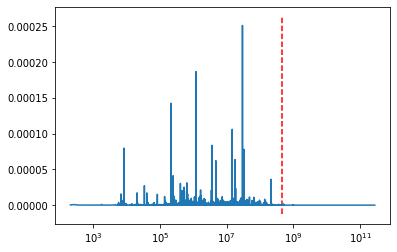

In [74]:
plt.figure()
plt.semilogx(pdf_w_axis, pdf)
ymin, ymax = plt.ylim()
plt.vlines(np.mean(wsort), ymin, ymax, linestyles='dashed', colors='r')

Text(0, 0.5, 'Probability density')

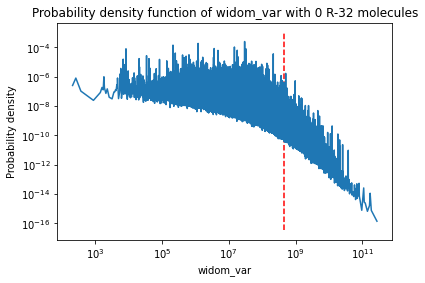

In [75]:
plt.figure()
plt.loglog(pdf_w_axis, pdf)
ymin, ymax = plt.ylim()
plt.vlines(np.mean(wsort), ymin, ymax, linestyles='dashed', colors='r')
plt.title("Probability density function of widom_var with 0 R-32 molecules")
plt.xlabel("widom_var")
plt.ylabel("Probability density")